# Mount and Imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/Cardiac Project/Registration_phase/based on doc2/

/content/gdrive/.shortcut-targets-by-id/1T4XU2DwFBpucge5DbMQ0wVZaRLkXQ564/Cardiac Project/Registration_phase/based on doc2


In [ ]:
%ls

dataset/  doc2.gsheet  manually_resize.ipynb  phase3.ipynb  scripts/


In [3]:
!pip install -q pydicom
!pip install simpleitk -q

     |████████████████████████████████| 1.9MB 32.2MB/s 
     |████████████████████████████████| 47.4MB 95kB/s 


In [5]:
import pydicom
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import json
import SimpleITK as sitk


# Functions

In [6]:
def determine_indexs(image):
    H , W = image.shape
    for i in range(W): 
        if image[120,i] != 0:
            left = i
            break
    for i in range(H): 
        if image[i , 320] != 0:
            top = i
            break
    return left , top

In [7]:
def crop_image(image , left , top):
    if len(image.shape) == 3:
      return crop_image3d(image, left, top)
    elif len(image.shape) == 2:
      return crop_image2d(image, left, top)
  
def crop_image2d(image , left , top):
    H , W = image.shape
    right = W - left
    bottom = H - top
    image = image[top:bottom , left:right ]
    return image 

def crop_image3d(image , left , top):
    H , W, D = image.shape
    right = W - left
    bottom = H - top
    image = image[top:bottom , left:right, 0:D]
    return image

In [8]:
def get_segment_cordinates(image, seg_color, show=True):
  cordinates = []
  img = image.copy()
  segment_pixel_nb = 0
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      R, G, B = img[i][j]
      in_segment = check_color(seg_color, R, G, B) 
      if seg_color == 'yellow' or seg_color == 'blue':
        in_segment = in_segment or check_color('pink', R, G, B)
      if in_segment:
          img[i][j] = [255, 255, 255]
          segment_pixel_nb += 1
          cordinates.append((i, j))
  if show:
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    ax1.imshow(image, cmap='gray')
    ax2.imshow(img, cmap='gray')
    if seg_color == 'yellow':
      ax1.set_title("orginal")
      ax2.set_title("scar")
  return cordinates

def check_color(color, R, G, B):
  if color == 'green' and (G - R) > 100 and (G - B) > 100:
    return True
  if color == 'red' and R>B and R > G + 100 and R > B + 100:
    return True
  if (color == 'blue') and (B>G)  and (B>R) and (R>100) and (B>100) and (G>100):
    return True  
  if color == 'yellow' and abs(R - G) < 60 and (R - B) > 40 and (G - B) > 40:
    return True
  if color == 'pink' and abs(R - B) < 80 and R > 170 and B > 170 and G < 80:
    return True
  return False

In [9]:
def is_in(x, y, cordinates, treshold=0):
  TR, TL, BR, BL = get_surrounding(x, y, cordinates)
  if len(TR) > treshold and len(TL) > treshold and len(BR) > treshold and len(BL) > treshold:
    return True
  return False

def get_surrounding(x, y, cordinates):
  top_right = []
  top_left = []
  bottom_right = []
  bottom_left = []
  for i, j in cordinates:
    if x-i > 0 and y-j < 0:
      top_right.append((i, j))
    elif x-i > 0 and y-j > 0:
      top_left.append((i, j))
    elif x-i < 0 and y-j < 0:
      bottom_right.append((i, j))
    elif x-i < 0 and y-j > 0:
      bottom_left.append((i, j))
  return top_right, top_left, bottom_right, bottom_left

In [10]:
def get_pixels_in_contour(image, contour_color, show=True):
  img = image.copy()
  contour_cords = get_segment_cordinates(img, contour_color, show=False)
  sorted_by_i = sorted(contour_cords, key=lambda x: x[0])
  min_i = sorted_by_i[0][0]
  max_i = sorted_by_i[-1][0]
  sorted_by_j = sorted(contour_cords, key=lambda x: x[1])
  min_j = sorted_by_j[0][1]
  max_j = sorted_by_j[-1][1]
  inside_contour_cords = []
  for i in range(min_i, max_i + 1):
    for j in range(min_j, max_j + 1):
      if is_in(i, j, contour_cords):
        inside_contour_cords.append((i, j))
        img[i][j] = [0, 0, 255]
  if show:
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    ax1.imshow(image , cmap='gray')
    ax1.set_title("orginal")
    ax2.imshow(img , cmap='gray')
    ax2.set_title("inside")
  return inside_contour_cords

In [11]:
def get_pixels_between_contours(image, show=True):
  img = image.copy()
  green_contour_cords = get_segment_cordinates(img, 'green', show=False)
  red_contour_cords = get_segment_cordinates(img, 'red', show=False)
  sorted_by_i = sorted(green_contour_cords, key=lambda x: x[0])
  min_i = sorted_by_i[0][0]
  max_i = sorted_by_i[-1][0]
  sorted_by_j = sorted(green_contour_cords, key=lambda x: x[1])
  min_j = sorted_by_j[0][1]
  max_j = sorted_by_j[-1][1]
  between_contours_cords = []
  for i in range(min_i, max_i + 1):
    for j in range(min_j, max_j + 1):
      if is_in(i, j, green_contour_cords) and not is_in(i, j, red_contour_cords):
        if (i, j) not in red_contour_cords:
          between_contours_cords.append((i, j))
          img[i][j] = [255, 255, 255]
  if show:
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    ax1.imshow(image , cmap='gray')
    ax1.set_title("orginal")
    ax2.imshow(img , cmap='gray')
    ax2.set_title("between")
  return between_contours_cords

In [12]:
def get_healthy(image, scar_color='yellow', show=True):
  img = image.copy()
  between = get_pixels_between_contours(img, show=show)
  scar = get_segment_cordinates(img, scar_color, show=show)
  healthy = []
  for cord in between:
    if cord not in scar:
      healthy.append(cord)
      i, j = cord
      img[i][j] = [255, 255, 255]
  if show:
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    ax1.imshow(image , cmap='gray')
    ax1.set_title("orginal")
    ax2.imshow(img , cmap='gray')
    ax2.set_title("healty")
  return healthy

In [13]:
def blur_scar_3d(image, scar_color='yellow', use_min=False, show=True):
  img = image.copy()
  scar = get_segment_cordinates(img, scar_color, show=False)
  healthy = get_healthy(img, scar_color=scar_color, show=False)
  avg = [0, 0, 0]
  min_ = [255, 255, 255]
  for i, j in healthy:
    avg = np.add(avg, img[i][j])
    if img[i][j][0] < min_[0]:
      min_ = img[i][j]
  avg = np.divide(avg, len(healthy))
  np.array(avg, dtype=np.uint8)
  for i, j in scar:
    if use_min:
      img[i][j] = min_
    else:
      img[i][j] = avg
  if show:
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    ax1.imshow(image , cmap='gray')
    ax1.set_title("orginal")
    ax2.imshow(img , cmap='gray')
    ax2.set_title("blurred_3d")
  return img

def blur_scar_2d(image, target_image=None, scar_color='yellow', show=True):
  img = image.copy()
  scar = get_segment_cordinates(img, scar_color, show=False)
  healthy = get_healthy(img, scar_color=scar_color, show=False)
  if target_image is not None:
    img = target_image.copy()
  else:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  avg = 0
  for i, j in healthy:
    avg += img[i][j]
  avg /= len(healthy)
  for i, j in scar:
    img[i][j] = avg
  if show:
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    ax1.imshow(image , cmap='gray')
    ax1.set_title("orginal")
    ax2.imshow(img , cmap='gray')
    ax2.set_title("blurred_2d")
  return img


# 1. Main data

In [21]:
cine_path = './746603/img0019--67.6208.png'
lge_path = './746603/img0010--66.0209.png'
C_lge_path = './dataset/ok5/670643/1/results/img0008-unknown_c_lge.png'
# C_lge_path = './dataset/ok1,2/1216198/1/results/img0005-unknown_c_lge.png'

In [22]:
cine = cv2.imread(cine_path , cv2.IMREAD_GRAYSCALE)
lge = cv2.imread(lge_path , cv2.IMREAD_GRAYSCALE)
C_lge = cv2.imread(C_lge_path)
C_lge = cv2.cvtColor(C_lge, cv2.COLOR_RGB2BGR)

In [ ]:
# C_lge = pydicom.dcmread(C_lge_path)
# C_lge = C_lge.pixel_array

ValueError: ignored

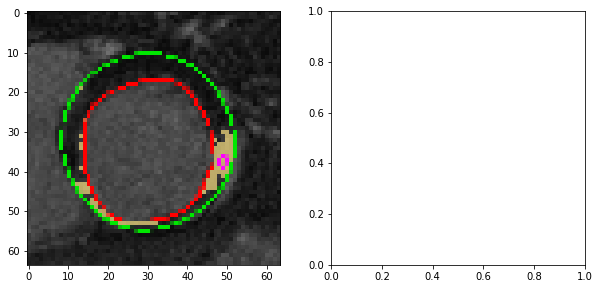

In [16]:
# fig , (ax1 , ax2 , ax3) = plt.subplots(1, 3, figsize=(20 ,20))
# ax1.imshow(cine , cmap='gray')
# ax2.imshow(lge , cmap='gray')
# ax3.imshow(C_lge, cmap='gray')

fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(10 ,10))
ax1.imshow(C_lge, cmap='gray')
ax2.imshow(crop_image(C_lge , 170 , 130), cmap='gray')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in ubyte_scalars


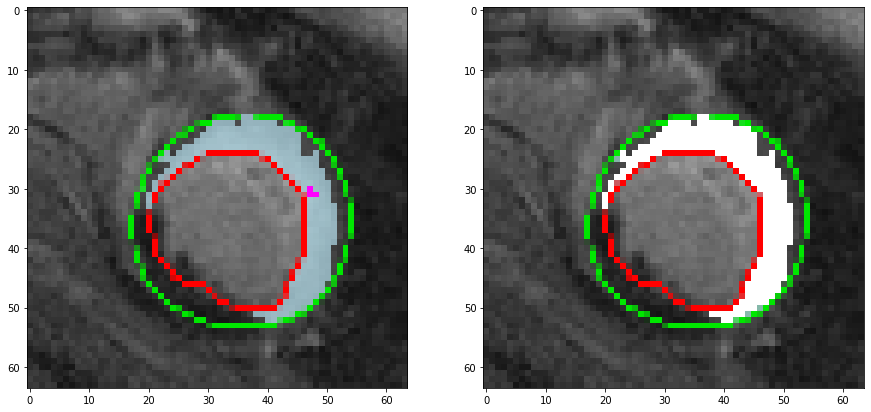

In [23]:
_ = get_segment_cordinates(C_lge, 'blue', show=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in ubyte_scalars


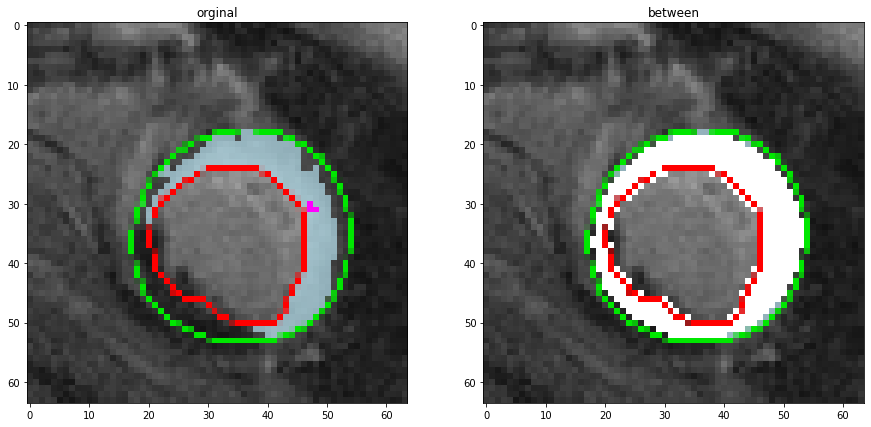

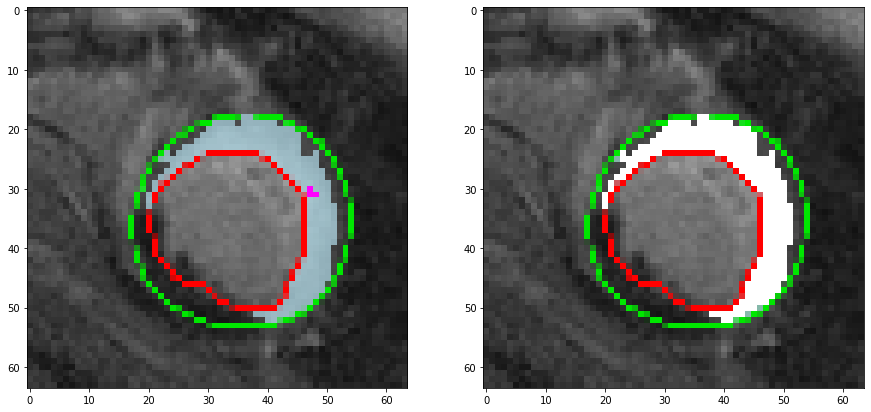

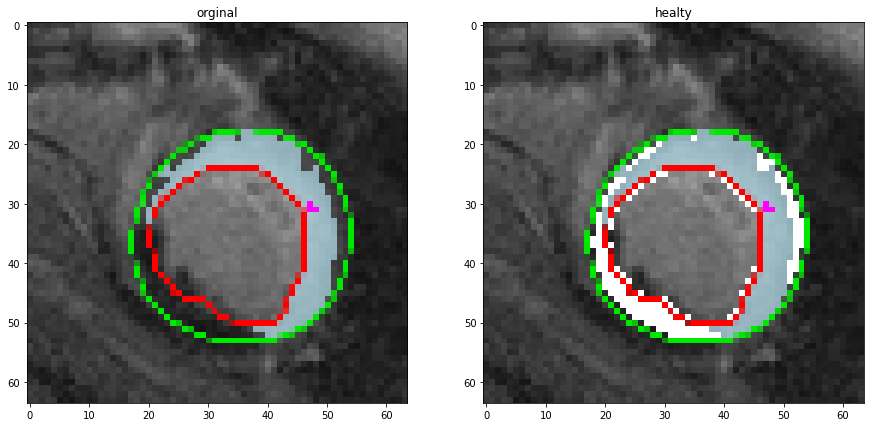

In [24]:
_ = get_healthy(C_lge, scar_color='blue')
# _ = get_healthy(crop_image(C_lge , 170 , 130))

# 2. Crop Margins

In [ ]:
# determine margin indexes for C_lge image
left_margin , top_margin = determine_indexs(cv2.cvtColor(C_lge, cv2.COLOR_RGB2GRAY))
print(left_margin , top_margin)

# Cropping
cropped_C_lge = crop_image(C_lge , left_margin , top_margin)

0 40


((512, 512, 3), (432, 512, 3))

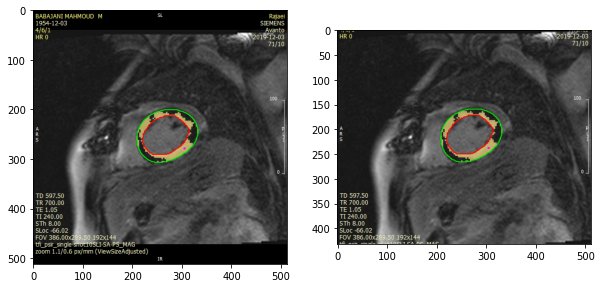

In [ ]:
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize=(10 ,10))
ax1.imshow(C_lge , cmap = 'gray')
ax2.imshow(cropped_C_lge , cmap = 'gray')
C_lge.shape, cropped_C_lge.shape

# 3. Pad and resize

In [ ]:
lge.shape, C_lge.shape

((144, 192), (512, 512, 3))

In [ ]:
192*(0.83)

159.35999999999999

In [ ]:
192 - 159

33

In [ ]:
left_pad = 33
top_pad = 0
print(left_pad , top_pad)

33 0


((432, 512, 3), (432, 578, 3))

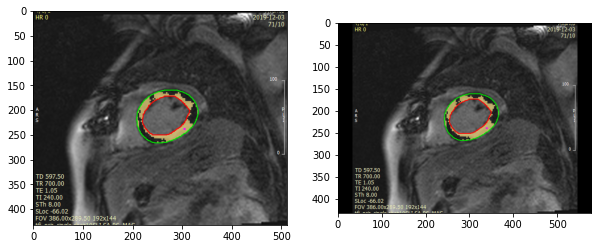

In [ ]:
# padding
C_lge_pad = pad_image(cropped_C_lge , left_pad , top_pad)

fig , (ax1 , ax2) = plt.subplots(1, 2, figsize=(10 ,10))
ax1.imshow(cropped_C_lge , cmap = 'gray')
ax2.imshow(C_lge_pad , cmap = 'gray')
cropped_C_lge.shape, C_lge_pad.shape

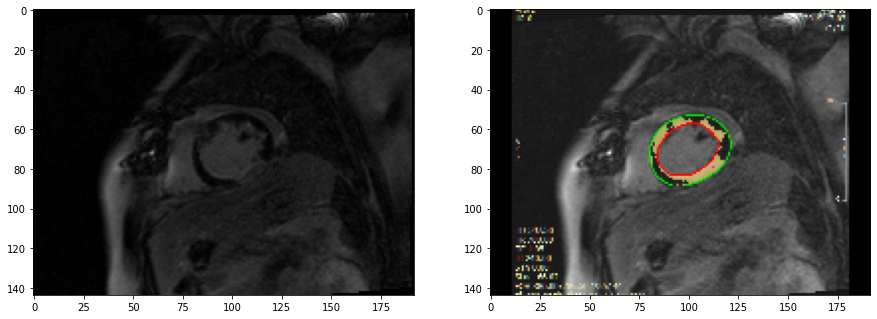

In [ ]:
# resize
C_lge_resized = cv2.resize(C_lge_pad, (lge.shape[1] , lge.shape[0]))

fig , (ax1 , ax2) = plt.subplots(1, 2, figsize=(15 ,15))
ax1.imshow(lge , cmap='gray')
ax2.imshow(C_lge_resized , cmap = 'gray')

# 4. Extract BB

## Data

In [ ]:
df = pd.read_csv('../phase_3_segmentation/746603/746603.csv')

## Functions

In [ ]:
def Extract_bb_class(meta_data, image_name):
    
    # extract Label column
    this_image_Label = json.loads(meta_data[meta_data['External ID'] == image_name].Label.iloc[0])    
    # Bounding Box
    bbox_ax = this_image_Label['objects'][0]['bbox']          
    # Class Type
    class_type = this_image_Label['classifications'][0]['answer']['value']

    return bbox_ax, class_type

In [ ]:
def crop_this(image , bbox_ax):
    cropped_image = image[bbox_ax['top']:bbox_ax['top']+bbox_ax['height'], bbox_ax['left']:bbox_ax['left']+bbox_ax['width']]
    shape = cropped_image.shape
    #image_2d = cropped_image.astype(float)
    #image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0
    #image_2d_scaled = np.uint8(image_2d_scaled)
    #image_2d_scaled = image_2d_scaled.astype(np.uint8)
    return cropped_image

## Execute

In [ ]:
bbox_ax_lge, class_type = Extract_bb_class(df, image_name = "img0010--66.0209.png")

In [ ]:
bbox_ax_cine, class_type = Extract_bb_class(df, image_name = "img0019--67.6208.png")

In [ ]:
bb_cine = crop_this(cine , bbox_ax_cine)
bb_lge = crop_this(lge , bbox_ax_lge)
bb_C_lge = crop_this(C_lge_resized , bbox_ax_lge)

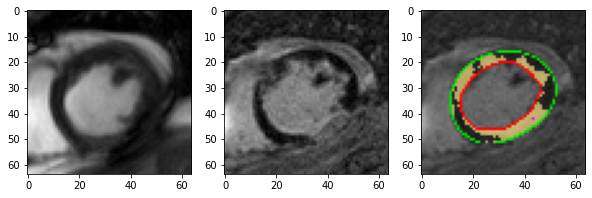

In [ ]:
fig , (ax1 , ax2 , ax3) = plt.subplots(1,3, figsize=(10 ,10))
ax1.imshow(bb_cine , cmap='gray')
ax2.imshow(bb_lge , cmap='gray')
ax3.imshow(bb_C_lge , cmap = 'gray')

# Scar Elimination

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in ubyte_scalars


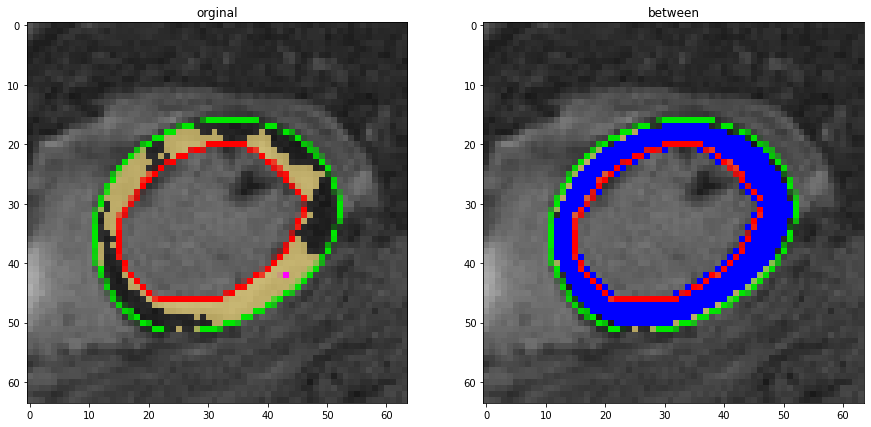

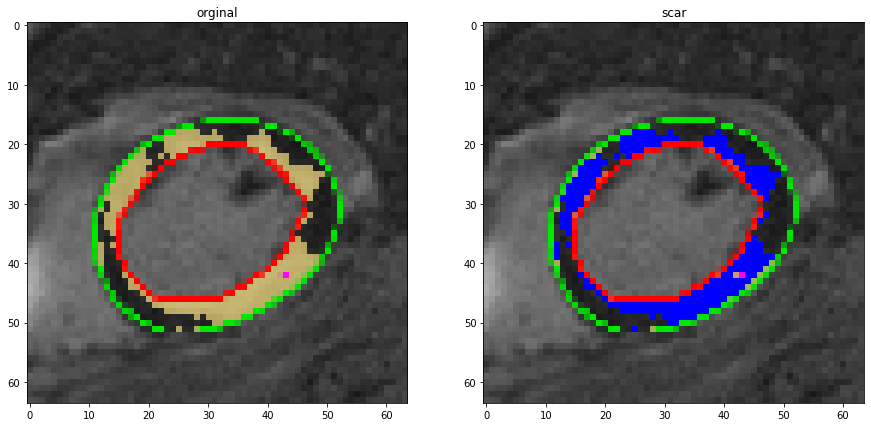

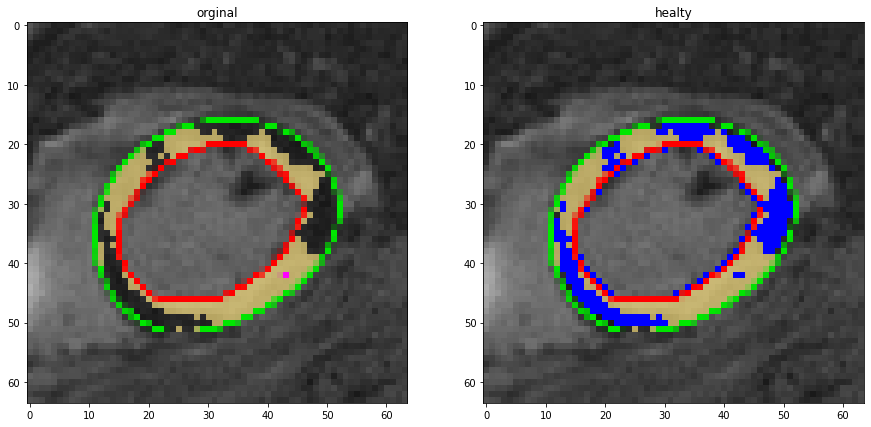

In [ ]:
_ = get_healthy(bb_C_lge)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in ubyte_scalars


Text(0.5, 1.0, 'blurred_2d')

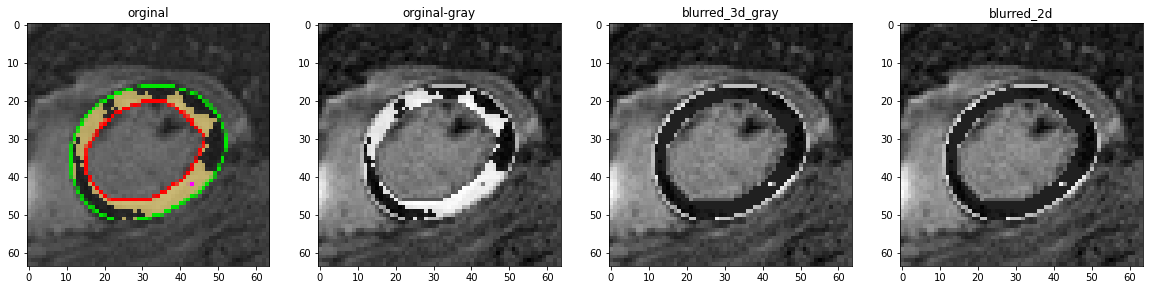

In [ ]:
# based on contour LGE
img = bb_C_lge
blurred_3d = blur_scar_3d(img, show=False)
blurred_2d = blur_scar_2d(img, show=False)

fig , (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 20))
ax1.imshow(img , cmap='gray')
ax1.set_title("orginal")
ax2.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) , cmap='gray')
ax2.set_title("orginal-gray")
ax3.imshow(cv2.cvtColor(blurred_3d, cv2.COLOR_RGB2GRAY) , cmap='gray')
ax3.set_title("blurred_3d_gray")
ax4.imshow(blurred_2d , cmap='gray')
ax4.set_title("blurred_2d")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in ubyte_scalars


Text(0.5, 1.0, 'blurred_2d')

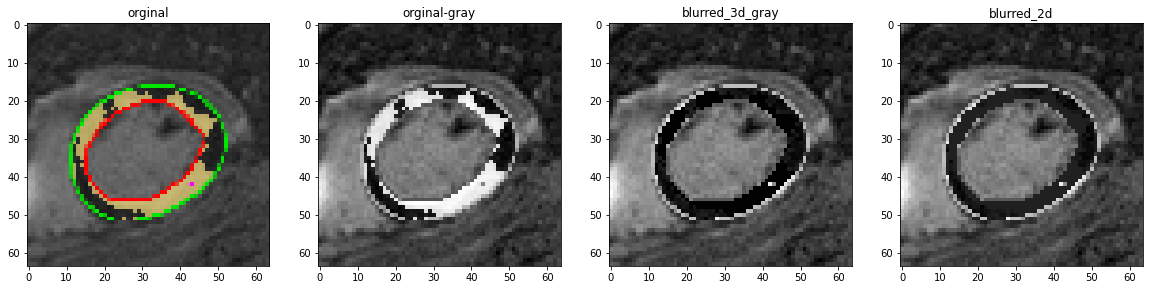

In [ ]:
# based on contour LGE with max instead of avg
img = bb_C_lge
blurred_3d = blur_scar_3d(img, use_max=True, show=False)
blurred_2d = blur_scar_2d(img, show=False)

fig , (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 20))
ax1.imshow(img , cmap='gray')
ax1.set_title("orginal")
ax2.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) , cmap='gray')
ax2.set_title("orginal-gray")
ax3.imshow(cv2.cvtColor(blurred_3d, cv2.COLOR_RGB2GRAY) , cmap='gray')
ax3.set_title("blurred_3d_gray")
ax4.imshow(blurred_2d , cmap='gray')
ax4.set_title("blurred_2d")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in ubyte_scalars


Text(0.5, 1.0, 'blurred_2d')

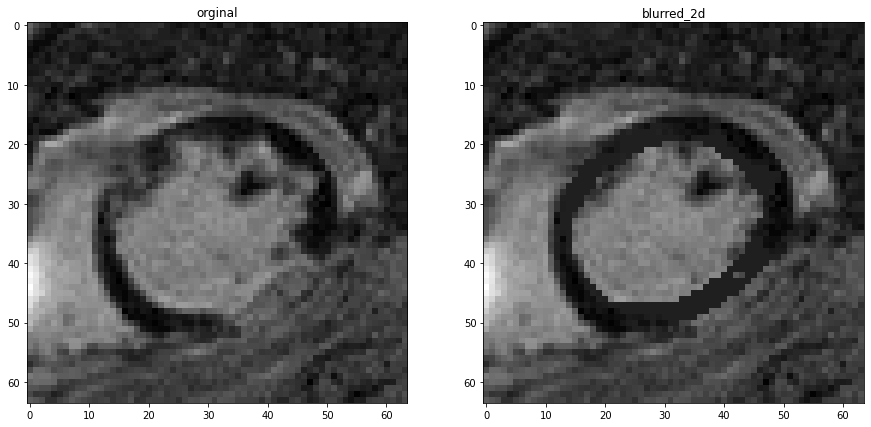

In [ ]:
# based on non-contour LGE
blurred_2d = blur_scar_2d(bb_C_lge, target_image=bb_lge, show=False)

fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.imshow(bb_lge , cmap='gray')
ax1.set_title("orginal")
ax2.imshow(blurred_2d , cmap='gray')
ax2.set_title("blurred_2d")


# 6. Rigid Transformation - Simple itk

In [ ]:
fixed_image = bb_cine
moving_image = bb_lge
c_moving = bb_C_lge

In [ ]:
fixed = sitk.GetImageFromArray(fixed_image)
fixed = sitk.Cast(fixed, sitk.sitkFloat32)

moving = sitk.GetImageFromArray(moving_image)
moving = sitk.Cast(moving, sitk.sitkFloat32)

c_moving = sitk.GetImageFromArray(c_moving)
c_moving = sitk.Cast(c_moving, sitk.sitkFloat32)

In [ ]:
outTx = R.Execute(fixed, moving)

In [ ]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)

In [ ]:
out1 = resampler.Execute(moving)
out2 = resampler.Execute(c_moving)


In [ ]:
fix = sitk.GetArrayFromImage(sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8))
mov = sitk.GetArrayFromImage(sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8))
outt1 = sitk.GetArrayFromImage(sitk.Cast(sitk.RescaleIntensity(out1), sitk.sitkUInt8))
outt2 = sitk.GetArrayFromImage(sitk.Cast(sitk.RescaleIntensity(out2), sitk.sitkUInt8))

#befor = sitk.GetArrayFromImage(sitk.Compose(sitk.GetImageFromArray(fix), sitk.GetImageFromArray(mov), sitk.GetImageFromArray(fix) // 2. + sitk.GetImageFromArray(mov) // 2.))
#after = sitk.GetArrayFromImage(sitk.Compose(sitk.GetImageFromArray(fix), sitk.GetImageFromArray(outt), sitk.GetImageFromArray(fix) // 2. + sitk.GetImageFromArray(outt) // 2.))


fig , (ax1 , ax2 , ax3 , ax4 ) = plt.subplots(1,4, figsize=(13,10))
ax1.imshow(mov, cmap = 'gray')
ax2.imshow(fix, cmap = 'gray')
ax3.imshow(outt1, cmap = 'gray')
ax4.imshow(outt2, cmap = 'gray')
#ax5.imshow(after, cmap = 'gray')

In [ ]:
C_lge = cv2.cvtColor(C_lge, cv2.COLOR_RGB2GRAY)

In [ ]:
s = C_lge

In [ ]:
for i in range(C_lge.shape[0]):
    for j in range(C_lge.shape[1]):
        if C_lge[i , j].tolist() in range(160 , 185):
            s[i , j] = 255

In [ ]:
fig , (ax1 , ax2 ) = plt.subplots(1,2, figsize=(20,20))
ax1.imshow(C_lge, cmap = 'gray')
ax2.imshow(s, cmap = 'gray')


# 8. Voxel Morph

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
from torchvision import transforms

import random
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split


import skimage.io as io
from skimage.transform import resize
#import multiprocessing as mp #


#import gc #
#from matplotlib.lines import Line2D #
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
use_gpu = torch.cuda.is_available()

In [ ]:
def read_dataset(path):
    cine_dataset = []
    lge_dataset = []
    for filename in tqdm(glob.iglob(path + "**/*.png" , recursive = True)):
        class_type = filename.split('/')[3]
        image_name = filename.split('/')[4]
        image = cv2.imread(filename ,  cv2.IMREAD_GRAYSCALE)
        image = transforms.ToTensor()(image)
        if class_type == 'cine_images':
            cine_dataset.append((image , image_name))
        if class_type == 'lge_images':
            lge_dataset.append((image , image_name))

    cine_dataset.sort(key = lambda x: x[1]) 
    lge_dataset.sort(key = lambda x: x[1]) 
 
    dataset = []
    for i in range(len(cine_dataset)):
        cine_image = cine_dataset[i][0]
        lge_image = lge_dataset[i][0]
        dataset.append((cine_image , lge_image))

    return dataset

In [ ]:
path = './phase_2_voxel_morph/voxelMorph/'

In [ ]:
dataset = read_dataset(path)

In [ ]:
train_dataset , test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [ ]:
train_loader = data.DataLoader(train_dataset ,
                               batch_size = 20,
                               shuffle = True,
                               num_workers = 2,
                               worker_init_fn =  np.random.seed(42))  
test_loader = data.DataLoader(test_dataset ,
                               batch_size = 20,
                               shuffle = True,
                               num_workers =  2,
                               worker_init_fn =  np.random.seed(42))                      

In [ ]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        """
        This function creates one contracting block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This function creates one expansive block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        return block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This returns final block
        """
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU()
                )
        return block

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=32)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(32, 64)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(64, 128)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        mid_channel = 128
        self.bottleneck = torch.nn.Sequential(
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel, out_channels=mid_channel * 2, padding=1),
                                torch.nn.BatchNorm2d(mid_channel * 2),
                                torch.nn.ReLU(),
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel*2, out_channels=mid_channel, padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                                torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=mid_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(256, 128, 64)
        self.conv_decode2 = self.expansive_block(128, 64, 32)
        self.final_layer = self.final_block(64, 32, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        """
        This layer crop the layer from contraction block and concat it with expansive block vector
        """
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1)
        final_layer = self.final_layer(decode_block1)
        return  final_layer


In [ ]:
class SpatialTransformation(nn.Module):
    def __init__(self, use_gpu=False):
        self.use_gpu = use_gpu
        super(SpatialTransformation, self).__init__()

    def meshgrid(self, height, width):
        x_t = torch.matmul(torch.ones([height, 1]), torch.transpose(torch.unsqueeze(torch.linspace(0.0, width -1.0, width), 1), 1, 0))
        y_t = torch.matmul(torch.unsqueeze(torch.linspace(0.0, height - 1.0, height), 1), torch.ones([1, width]))

        x_t = x_t.expand([height, width])
        y_t = y_t.expand([height, width])
        if self.use_gpu==True:
            x_t = x_t.cuda()
            y_t = y_t.cuda()

        return x_t, y_t

    def repeat(self, x, n_repeats):
        rep = torch.transpose(torch.unsqueeze(torch.ones(n_repeats), 1), 1, 0)
        rep = rep.long()
        x = torch.matmul(torch.reshape(x, (-1, 1)), rep)
        if self.use_gpu:
            x = x.cuda()
        return torch.squeeze(torch.reshape(x, (-1, 1)))


    def interpolate(self, im, x, y):
        im = im.permute(0,2,3,1)
        im = F.pad(im, (0,0,1,1,1,1,0,0))
        
        batch_size, height, width, channels = im.shape
        batch_size, out_height, out_width = x.shape

        x = x.reshape(1, -1)
        y = y.reshape(1, -1)

        x = x + 1
        y = y + 1

        max_x = width - 1
        max_y = height - 1

        x0 = torch.floor(x).long()
        x1 = x0 + 1
        y0 = torch.floor(y).long()
        y1 = y0 + 1

        x0 = torch.clamp(x0, 0, max_x)
        x1 = torch.clamp(x1, 0, max_x)
        y0 = torch.clamp(y0, 0, max_y)
        y1 = torch.clamp(y1, 0, max_y)

        dim2 = width
        dim1 = width*height
        base = self.repeat(torch.arange(0, batch_size)*dim1, out_height*out_width)

        base_y0 = base + y0*dim2
        base_y1 = base + y1*dim2

        idx_a = base_y0 + x0
        idx_b = base_y1 + x0
        idx_c = base_y0 + x1
        idx_d = base_y1 + x1

        # use indices to lookup pixels in the flat image and restore
        # channels dim
        im_flat = torch.reshape(im, [-1, channels])
        im_flat = im_flat.float()
        dim, _ = idx_a.transpose(1,0).shape
        Ia = torch.gather(im_flat, 0, idx_a.transpose(1,0).expand(dim, channels))
        Ib = torch.gather(im_flat, 0, idx_b.transpose(1,0).expand(dim, channels))
        Ic = torch.gather(im_flat, 0, idx_c.transpose(1,0).expand(dim, channels))
        Id = torch.gather(im_flat, 0, idx_d.transpose(1,0).expand(dim, channels))

        # and finally calculate interpolated values
        x1_f = x1.float()
        y1_f = y1.float()

        dx = x1_f - x
        dy = y1_f - y

        wa = (dx * dy).transpose(1,0)
        wb = (dx * (1-dy)).transpose(1,0)
        wc = ((1-dx) * dy).transpose(1,0)
        wd = ((1-dx) * (1-dy)).transpose(1,0)

        output = torch.sum(torch.squeeze(torch.stack([wa*Ia, wb*Ib, wc*Ic, wd*Id], dim=1)), 1)
        output = torch.reshape(output, [-1, out_height, out_width, channels])
        return output.permute(0,3,1,2)

    def forward(self, moving_image, deformation_matrix):
        dx = deformation_matrix[:, :, :, 0]
        dy = deformation_matrix[:, :, :, 1]

        batch_size, height, width = dx.shape

        x_mesh, y_mesh = self.meshgrid(height, width)

        x_mesh = x_mesh.expand([batch_size, height, width])
        y_mesh = y_mesh.expand([batch_size, height, width])
        x_new = dx + x_mesh
        y_new = dy + y_mesh

        return self.interpolate(moving_image, x_new, y_new)


In [ ]:
class VoxelMorph2d(nn.Module):
    def __init__(self, in_channels, use_gpu=False):
        super(VoxelMorph2d, self).__init__()
        self.unet = UNet(in_channels, 2)
        self.spatial_transform = SpatialTransformation(use_gpu)
        if use_gpu:
            self.unet = self.unet.cuda()
            self.spatial_transform = self.spatial_transform.cuda()

    def forward(self, moving_image, fixed_image):
        
        x = torch.cat([moving_image, fixed_image], dim=1)
        deformation_matrix = self.unet(x).permute(0,2,3,1)
        registered_image = self.spatial_transform(moving_image, deformation_matrix)
        return registered_image , deformation_matrix

In [ ]:
def cross_correlation_loss(I, J, n):

    batch_size, channels, xdim, ydim = I.shape
    I2 = torch.mul(I, I)
    J2 = torch.mul(J, J)
    IJ = torch.mul(I, J)
    sum_filter = torch.ones((1, channels, n, n))
    if use_gpu:
        sum_filter = sum_filter.cuda()
    I_sum = torch.conv2d(I, sum_filter, padding=1, stride=(1,1))
    J_sum = torch.conv2d(J, sum_filter,  padding=1 ,stride=(1,1))
    I2_sum = torch.conv2d(I2, sum_filter, padding=1, stride=(1,1))
    J2_sum = torch.conv2d(J2, sum_filter, padding=1, stride=(1,1))
    IJ_sum = torch.conv2d(IJ, sum_filter, padding=1, stride=(1,1))
    win_size = n**2
    u_I = I_sum / win_size
    u_J = J_sum / win_size
    cross = IJ_sum - u_J*I_sum - u_I*J_sum + u_I*u_J*win_size
    I_var = I2_sum - 2 * u_I * I_sum + u_I*u_I*win_size
    J_var = J2_sum - 2 * u_J * J_sum + u_J*u_J*win_size
    cc = cross*cross / (I_var*J_var + np.finfo(float).eps)
    return torch.mean(cc)

def smooothing_loss(y_pred):
    y_pred = y_pred.permute(0,2,3,1)
    dy = torch.abs(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :])
    dx = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])

    dx = torch.mul(dx, dx)
    dy = torch.mul(dy, dy)
    d = torch.mean(dx) + torch.mean(dy)
    return d/2.0

def vox_morph_loss(y, ytrue, n=9, lamda=0.4):
    cc = cross_correlation_loss(y, ytrue, n)
    sm = smooothing_loss(y)
    #print("CC Loss", cc, "Gradient Loss", sm)
    loss = -1.0 * cc + lamda * sm
    return loss

def dice_score(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    top = 2 *  torch.sum(pred * target, [1, 2, 3])
    union = torch.sum(pred + target, [1, 2, 3])
    eps = torch.ones_like(union) * 1e-5
    bottom = torch.max(union, eps)
    dice = torch.mean(top / bottom)
    #print("Dice score", dice)
    return dice

In [ ]:
def train(model , train_loader ,epochs):
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_dice = 0
        for fixed_batch , moving_batch in train_loader:
            optimizer.zero_grad()
            fixed_batch = fixed_batch.to(device)
            moving_batch = moving_batch.to(device)
            registered_images , df = model(moving_batch , fixed_batch)
            train_loss = vox_morph_loss(registered_images, fixed_batch)
            train_loss.backward()
            optimizer.step()
            epoch_loss += train_loss.item()
            batch_dice = dice_score(registered_images ,fixed_batch )
            epoch_dice += batch_dice.item()
        print(epoch , epoch_loss/len(train_dataset) ,epoch_dice/len(train_dataset) )

In [ ]:
model = VoxelMorph2d(in_channels=2, use_gpu = use_gpu)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train(model , train_loader , epochs = 50)

In [ ]:
def test(model , test_loader):
    with torch.no_grad():
        all_loss = 0
        for fixed_batch , moving_batch in test_loader:
            fixed_batch = fixed_batch.to(device)
            moving_batch = moving_batch.to(device)
            registered_images , df = model(moving_batch , fixed_batch)
            test_loss = vox_morph_loss(registered_images, fixed_batch)
            all_loss += test_loss.item()
        print(all_loss/len(test_dataset)) 
        return fixed_batch, moving_batch , registered_images     

In [ ]:
fixed_batch, moving_batch , registered_images    = test(model , test_loader)

In [ ]:
sample = 7
fig , (ax1 , ax2 , ax3) = plt.subplots(1,3,figsize = (10,10))
ax1.imshow(moving_batch[sample].squeeze(0).cpu() , cmap = 'gray')
ax2.imshow(fixed_batch[sample].squeeze(0).cpu() , cmap = 'gray')
ax3.imshow(registered_images[sample].squeeze(0).cpu() , cmap = 'gray')

In [ ]:
from torchvision import transforms

In [ ]:
move = transforms.ToTensor()(outt1)
fixe = transforms.ToTensor()(fix)
move2 = transforms.ToTensor()(outt2)

move = move.unsqueeze(0)
fixe = fixe.unsqueeze(0)
move2 = move2.unsqueeze(0)


In [ ]:
fixed_batch = fixe.to(device)
moving_batch = move.to(device)
moving_batch2 = move2.to(device)

registered_images , dm = model(moving_batch , fixed_batch)
test_loss = vox_morph_loss(registered_images, fixed_batch)


In [ ]:
spatial_transform = SpatialTransformation(use_gpu)

In [ ]:
registered_image2 = spatial_transform(moving_batch2, dm)


In [ ]:
fig , (ax1 , ax2 , ax3 , ax4 , ax5) = plt.subplots(1,5,figsize = (20,50))
ax1.imshow(moving_batch.squeeze(0).squeeze(0).cpu() , cmap = 'gray')
ax2.imshow(moving_batch2.squeeze(0).squeeze(0).cpu().detach().numpy() , cmap = 'gray')
ax3.imshow(fixed_batch.squeeze(0).squeeze(0).cpu() , cmap = 'gray')
ax4.imshow(registered_images.squeeze(0).squeeze(0).cpu().detach().numpy() , cmap = 'gray')
ax5.imshow(registered_image2.squeeze(0).squeeze(0).cpu().detach().numpy() , cmap = 'gray')


# idea:

1.    Post Prosessing --> edge enhancment

2.   scar propagation

3.   scar elimination

4.   contour 


